# Approximation der Sinus funktion mit neuronalen Netzen

Neuronale Netze werden in der Regel für Funktionsapproximationen verwendet. Hierbei wir das Netzwerk mit einem Datensatz einer Funktion oder einem Messergebniss trainiert.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import clear_output

Da die Werte des Gradienten für jedes Neuron berechnet werden müssen, bietet es sich an diese parallel auszuführen. Dies wird in der Regel mit Grafikkarten realisiert.

In [31]:
device = torch.device("cuda") # sage PyTorch, es soll die Grafikkarte verwenden

In [32]:
# nun erstellen wir uns unser neuronales Netzwerk

# Hier sieht die Architektur wie folgt aus:
#
#  1 -> 32 -> 64 -> 32 -> 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.l1 = nn.Linear(1, 32)
        self.l2 = nn.Linear(32, 64)
        self.l3 = nn.Linear(64, 32)
        self.l4 = nn.Linear(32, 1)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        return self.l4(a)

In [33]:
data_set = [] # ein Speicher um unsere Eingabedaten zu speichern (x)
label_set = [] # ein Speicher um unsere Ausgabedaten zu speichern (sin(x))

# generiere einen Datensatz mit 80 Datenpunkten
for i in range(80):
    label_set.append([math.sin(i/4)])
    data_set.append([i/4])

# Normalisiere den Datensatz, da unser Netzwerk nur mit Eingaben und Ausgaben im Bereich zwischen -1 und 1 arbeiten kann
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

data_set = scaler.fit_transform(data_set)
label_set = scaler.fit_transform(label_set)

# Speichere ihn in einem speziellen Speicher des Frameworks und übergeb ihn der Grafikkarte
data = torch.FloatTensor(data_set).to(device)
labels = torch.FloatTensor(label_set).to(device)

In [34]:
model = Net().to(device) # speichere das Netzwerk in einer Variable und übergebe es der Grafikkarte
optimizer = torch.optim.SGD(model.parameters(), lr=0.001) # unser Optimierungsalgorithmus (Gradientenverfahren)

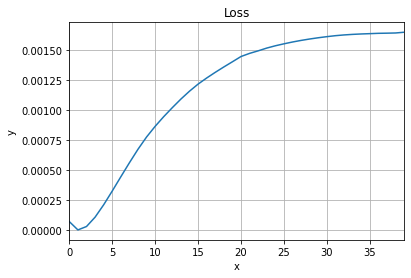

In [38]:
epochs = 1000 # die Anzahl der Trainings-Iterationen
loss_holder = [] # ein Speicher für die Werte der Loss-Funktion
for i in range(epochs):
    for j in range(80):
        
        y_pred = model(data[j]) # frage das Netwerk nach der momentanen Ausgabe Y bei der Eingabe X
        single_loss = F.mse_loss(y_pred, labels[j]) # definiere unsere Loss-Funktion (Mean Squared Error Loss)
        
        optimizer.zero_grad() # Lösche die Gradienten des Optimierungsalgorithmuses
        single_loss.backward() # berechne den Gradienten mit der momentanen Loss-Funktion
        optimizer.step() # Optimiere unser Netzwerk
    
    # Speichere den momentanen Wert der Loss-Funktion alle 25 Epochen    
    if i%25 == 1:
        loss_holder.append(single_loss.item())

# Zeige den Verlauf der Loss-Funktion in einem Graphen
clear_output()
plt.title('Loss')
plt.ylabel('y')
plt.xlabel('x')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(loss_holder)

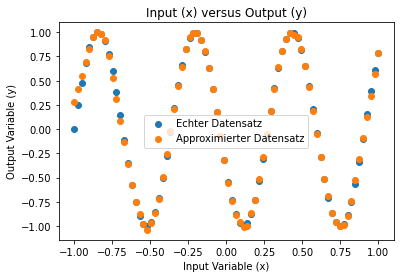

In [39]:
model.eval() # setze das Netzwerk in den Evaluations-Modus

approx_data = [] # ein speicher für den approximierten Datensatz

# generiere einen approximierten Datensatz
for i in range(80):
    approx_data.append(model(data[i]).item())
    
# zeige beide Datensätze in einer Grafik
pyplot.scatter(data_set,label_set, label='Echter Datensatz')
pyplot.scatter(data_set,approx_data, label='Approximierter Datensatz')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()